In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier as xgb
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

In [39]:
%%time
df = pd.read_csv('/Volumes/Mohs\'s_SSD/DeepLearning Models/DataSets/Predicting_Exoplanet_Habitability/hwc.csv')

CPU times: user 31.3 ms, sys: 13 ms, total: 44.2 ms
Wall time: 203 ms


Extremly Biased

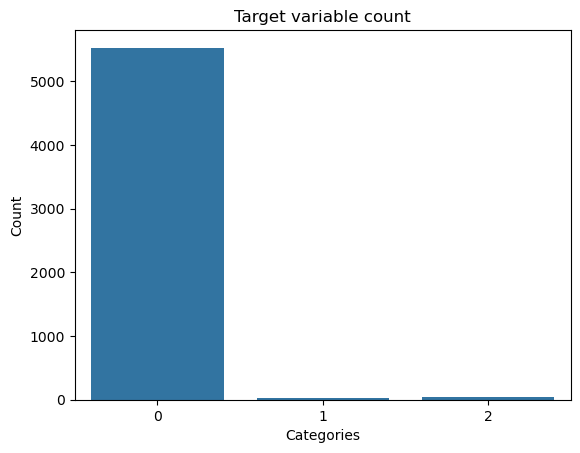

In [40]:
x = df['P_HABITABLE'].value_counts().values
y = df['P_HABITABLE'].value_counts().index

sns.barplot(x=y, y=x)  # Correct usage
plt.title('Target variable count')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [41]:
y = df['P_HABITABLE'].astype('uint8')
X = df.drop(['P_HABITABLE'], axis=1)

print(X.shape)
print(y.shape)

(5599, 117)
(5599,)


In [42]:
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
X[non_numeric_cols].head(10)

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_UPDATE,P_MASS_ORIGIN,S_NAME,S_NAME_HD,S_NAME_HIP,S_TYPE,S_RA_STR,S_DEC_STR,P_TYPE,S_TYPE_TEMP,S_RA_TXT,S_DEC_TXT,P_TYPE_TEMP,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020-04-02,Mass,OGLE-2016-BLG-1227L,NaN,NaN,NaN,17h42m23.31s,-33d45m35.2s,Jovian,NaN,17 42 23.31,-33 45 35.20,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2018-09-25,Mass,Kepler-276,NaN,NaN,NaN,19h34m16.37s,+39d02m10.72s,Neptunian,G,19 34 16.37,+39 02 10.72,Hot,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2019-04-16,M-R relationship,Kepler-829,NaN,NaN,NaN,18h49m19.88s,+42d27m49.73s,Superterran,G,18 49 19.88,+42 27 49.73,Hot,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2019-09-05,M-R relationship,K2-283,NaN,NaN,NaN,00h52m46.65s,+09d41m34.51s,Neptunian,K,00 52 46.65,+09 41 34.51,Hot,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2019-04-16,M-R relationship,Kepler-477,NaN,NaN,NaN,19h12m16.19s,+42d21m19.10s,Superterran,K,19 12 16.19,+42 21 19.10,Hot,Lyra,Lyr,Lyre
5,TOI-1260 c,Transit,Transiting Exoplanet Survey Satellite (TESS),2022-12-17,Mass,TOI-1260,NaN,NaN,K6 V,10h28m34.58s,+65d51m15.11s,Neptunian,K,10 28 34.58,+65 51 15.11,Hot,Ursa Major,UMa,Big Bear
6,HD 149143 b,Radial Velocity,Haute-Provence Observatory,2018-09-25,Msini,HD 149143,HD 149143,HIP 81022,G0,16h32m51.04s,+02d05m04.04s,Jovian,G,16 32 51.04,+02 05 04.04,Hot,Ophiuchus,Oph,Serpent Holder
7,HD 99492 b,Radial Velocity,W. M. Keck Observatory,2023-09-19,Msini,HD 99492,HD 99492,HIP 55848,K2 V,11h26m45.52s,+03d00m25.68s,Neptunian,K,11 26 45.52,+03 00 25.68,Hot,Leo,Leo,Lion
8,nu Oph c,Radial Velocity,Okayama Astrophysical Observatory,2023-09-19,Mass,nu Oph,HD 163917,HIP 88048,K0 III,17h59m01.58s,-09d46m26.88s,Jovian,K,17 59 01.58,-09 46 26.88,Hot,Ophiuchus,Oph,Serpent Holder
9,75 Cet b,Radial Velocity,Okayama Astrophysical Observatory,2023-09-19,Msini,75 Cet,HD 15779,HIP 11791,G3 III,02h32m09.40s,-01d02m06.10s,Jovian,G,02 32 09.40,-01 02 06.10,Hot,Cetus,Cet,Whale


Dropped: P_NAME, P_DISCOVERY_FACILITY, P_UPDATE, S_NAME, S_NAME_HD, S_NAME_HIP, S_TYPE,S_RA_STR, S_DEC_STR, S_RA_TXT, S_DEC_TXT, S_CONSTELLATION, S_CONSTELLATION_ABR ,S_CONSTELLATION_ENG 
Enconded:P_DETECTION, P_MASS_ORIGIN, S_TYPE_TEMP, P_TYPE_TEMP

In [43]:
# Columns to drop
cols_to_drop = [
    'P_NAME', 'P_DISCOVERY_FACILITY', 'P_UPDATE', 'S_NAME', 'S_NAME_HD', 'S_NAME_HIP',
    'S_TYPE', 'S_RA_STR', 'S_DEC_STR', 'S_RA_TXT', 'S_DEC_TXT',
    'S_CONSTELLATION', 'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG','P_YEAR'
]

# Drop columns
X = X.drop(columns=cols_to_drop, errors='ignore')  # ignore avoids errors if any col missing

# Columns to encode
cols_to_encode = ['P_DETECTION', 'P_MASS_ORIGIN', 'S_TYPE_TEMP', 'P_TYPE_TEMP']

# Apply Label Encoding to each
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cols_to_encode:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # convert to str in case of NaNs or mixed types
    label_encoders[col] = le                       # save encoder if you need inverse_transform later


In [44]:
X = X.dropna(subset=cols_to_encode)

In [45]:
nan_check = X.isna().sum()
print(nan_check)

P_DETECTION            0
P_MASS                 7
P_MASS_ERROR_MIN    3093
P_MASS_ERROR_MAX    3093
P_MASS_LIMIT           0
                    ... 
S_TIDAL_LOCK           4
P_HABZONE_OPT          0
P_HABZONE_CON          0
P_TYPE_TEMP            0
P_ESI                241
Length: 102, dtype: int64


Will definetly remove all the min and max cols and see what of the rest i can use simple_imputer(mean) on 

In [46]:
# Check which columns have "Min" or "Max" in their names
min_cols = X.columns[X.columns.str.contains('Min', case=False)]
max_cols = X.columns[X.columns.str.contains('Max', case=False)]

print("Columns with 'Min' in the name:", min_cols)
print("Columns with 'Max' in the name:", max_cols)

Columns with 'Min' in the name: Index(['P_MASS_ERROR_MIN', 'P_RADIUS_ERROR_MIN', 'P_PERIOD_ERROR_MIN',
       'P_SEMI_MAJOR_AXIS_ERROR_MIN', 'P_ECCENTRICITY_ERROR_MIN',
       'P_INCLINATION_ERROR_MIN', 'P_OMEGA_ERROR_MIN', 'S_MAG_ERROR_MIN',
       'S_DISTANCE_ERROR_MIN', 'S_TEMPERATURE_ERROR_MIN', 'S_MASS_ERROR_MIN',
       'S_RADIUS_ERROR_MIN', 'S_METALLICITY_ERROR_MIN', 'S_AGE_ERROR_MIN',
       'S_LOG_LUM_ERROR_MIN', 'S_LOG_G_ERROR_MIN', 'P_FLUX_MIN',
       'P_TEMP_EQUIL_MIN', 'P_TEMP_SURF_MIN', 'S_LUMINOSITY', 'S_HZ_OPT_MIN',
       'S_HZ_CON_MIN', 'S_HZ_CON0_MIN', 'S_HZ_CON1_MIN'],
      dtype='object')
Columns with 'Max' in the name: Index(['P_MASS_ERROR_MAX', 'P_RADIUS_ERROR_MAX', 'P_PERIOD_ERROR_MAX',
       'P_SEMI_MAJOR_AXIS_ERROR_MAX', 'P_ECCENTRICITY_ERROR_MAX',
       'P_INCLINATION_ERROR_MAX', 'P_OMEGA_ERROR_MAX', 'S_MAG_ERROR_MAX',
       'S_DISTANCE_ERROR_MAX', 'S_TEMPERATURE_ERROR_MAX', 'S_MASS_ERROR_MAX',
       'S_RADIUS_ERROR_MAX', 'S_METALLICITY_ERROR_MAX', 'S_A

In [47]:
Total = min_cols.append(max_cols)

In [48]:
X = X.drop(columns=Total, errors='ignore')

Will also drop anything with a very high Nan

In [49]:
X = X.drop(columns=['P_HABZONE_OPT','P_HABZONE_CON'], axis =1)

In [50]:
columns_to_drop_limit = X.columns[X.columns.str.contains('LIMIT', case=False)]
X.drop(columns=columns_to_drop_limit, inplace=True)

In [51]:
X.head(20)

,P_DETECTION,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_PERIOD,P_SEMI_MAJOR_AXIS,P_ECCENTRICITY,P_INCLINATION,P_OMEGA,S_RA,...,P_FLUX,P_TEMP_EQUIL,P_TEMP_SURF,P_TYPE,S_TYPE_TEMP,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_TYPE_TEMP,P_ESI
0,4,250.00000,1,13.900,NaN,3.40000,NaN,NaN,NaN,265.597130,...,NaN,NaN,NaN,Jovian,10,NaN,NaN,0.214133,3,NaN
1,9,16.60000,1,2.900,31.884000,0.19940,0.0000,86.920,NaN,293.568200,...,20.490365,541.984830,NaN,Neptunian,4,2.437046,2.097783,0.316980,1,0.272032
2,9,5.10000,0,2.110,6.883376,0.06780,0.0000,89.820,NaN,282.332830,...,238.528680,1001.117100,1130.60440,Superterran,4,2.827247,1.756317,0.459559,1,0.254763
3,9,12.20000,0,3.520,1.921036,0.02910,NaN,NaN,NaN,13.194368,...,353.357260,1104.468200,NaN,Neptunian,5,1.476943,0.568374,0.443760,1,0.193906
4,9,4.94000,0,2.070,11.119907,0.09110,0.0000,87.750,NaN,288.067450,...,51.163853,681.303340,769.42507,Superterran,5,1.759397,0.768502,0.386150,1,0.276721
5,9,13.20000,1,2.760,7.493134,0.06570,0.0000,87.970,0.000,157.144070,...,29.913640,595.754080,NaN,Neptunian,5,0.970206,0.124210,0.431924,1,0.260440
6,8,422.71390,3,13.600,4.071820,0.05300,0.0167,NaN,217.000,248.212670,...,797.092700,1353.487400,NaN,Jovian,4,4.039836,2.464949,0.484387,1,0.067319
7,8,25.50000,3,5.440,17.050300,0.12000,0.0340,NaN,154.300,171.689690,...,23.274946,559.406750,NaN,Neptunian,5,1.562657,0.446926,0.440120,1,0.188416
8,8,7838.32350,1,12.000,3180.600000,5.82900,0.1790,90.000,8.540,269.756600,...,2.349002,313.455190,NaN,Jovian,5,23.925651,0.604374,0.458413,1,0.337342
9,8,787.89662,3,13.300,696.620000,1.91200,0.0930,NaN,-157.600,38.039160,...,14.220357,493.878890,NaN,Jovian,4,19.425122,0.477158,0.573392,1,0.135621


In [52]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns  # Select numeric columns
imputer = SimpleImputer(strategy='median')  # You can also use strategy='mean'

X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

Now the imputation


In [53]:
# Example of imputing numerical columns with the median
numerical_cols = ['P_MASS', 'P_RADIUS', 'P_SEMI_MAJOR_AXIS', 'S_MAG', 'S_TEMPERATURE']  # Adjust column names
imputer = SimpleImputer(strategy='median')

X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

Now the encoding


In [54]:
print(X.dtypes)

P_DETECTION          float64
P_MASS               float64
P_MASS_ORIGIN        float64
P_RADIUS             float64
P_PERIOD             float64
P_SEMI_MAJOR_AXIS    float64
P_ECCENTRICITY       float64
P_INCLINATION        float64
P_OMEGA              float64
S_RA                 float64
S_DEC                float64
S_MAG                float64
S_DISTANCE           float64
S_TEMPERATURE        float64
S_MASS               float64
S_RADIUS             float64
S_METALLICITY        float64
S_AGE                float64
S_LOG_LUM            float64
S_LOG_G              float64
P_ESCAPE             float64
P_POTENTIAL          float64
P_GRAVITY            float64
P_DENSITY            float64
P_HILL_SPHERE        float64
P_DISTANCE           float64
P_PERIASTRON         float64
P_APASTRON           float64
P_DISTANCE_EFF       float64
P_FLUX               float64
P_TEMP_EQUIL         float64
P_TEMP_SURF          float64
P_TYPE                object
S_TYPE_TEMP          float64
S_SNOW_LINE   

In [55]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = X.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1)

In [58]:
tree_clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [59]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = tree_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9982142857142857


Yup this is wildly overfit
we will have to upsample the true cases

In [60]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Optional: Check new class distribution
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())


Before SMOTE: P_HABITABLE
0    4417
2      36
1      26
Name: count, dtype: int64
After SMOTE: P_HABITABLE
0    4417
1    4417
2    4417
Name: count, dtype: int64


That's looking alot better


In [61]:
tree_clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree_clf.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=3, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1112
           1       1.00      1.00      1.00         3
           2       0.80      0.80      0.80         5

    accuracy                           1.00      1120
   macro avg       0.93      0.93      0.93      1120
weighted avg       1.00      1.00      1.00      1120



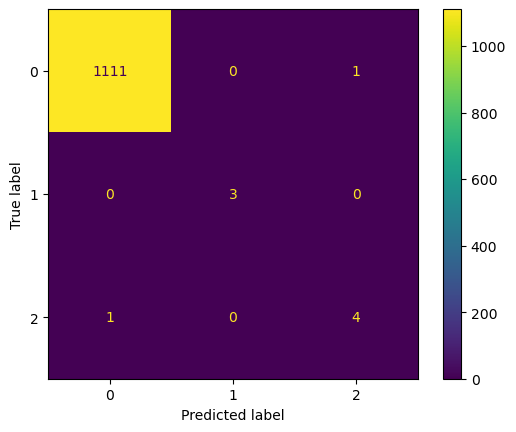

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Let's Try something else


In [63]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

In [64]:
# Loop through each split in the Stratified K-Fold
for train_index, test_index in skf.split(X_train_sm, y_train_sm):
    # Split the data into training and test sets for this fold
    X_train_run, X_test_run = X_train_sm.iloc[train_index], X_train_sm.iloc[test_index]
    y_train_run, y_test_run = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]
    

    model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
    model.fit(X_train_run, y_train_run)
    
    # Make predictions
    y_pred = model.predict(X_test_run)
    accuracy = accuracy_score(y_test_run, y_pred)
    print(f"Accuracy: {accuracy}")
    

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9996226415094339
Accuracy: 0.9996226415094339


In [65]:
# Assuming 'model' is your trained Decision Tree
feature_importances = model.feature_importances_
feature_names = X_train_sm.columns

# Pair feature names with their importance
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


P_RADIUS: 0.4996229616627497
P_TEMP_SURF: 0.4989631178843109
P_FLUX: 0.0008482562336959039
P_TYPE_TEMP: 0.0005656642192435743
P_DETECTION: 0.0
P_MASS: 0.0
P_MASS_ORIGIN: 0.0
P_PERIOD: 0.0
P_SEMI_MAJOR_AXIS: 0.0
P_ECCENTRICITY: 0.0
P_INCLINATION: 0.0
P_OMEGA: 0.0
S_RA: 0.0
S_DEC: 0.0
S_MAG: 0.0
S_DISTANCE: 0.0
S_TEMPERATURE: 0.0
S_MASS: 0.0
S_RADIUS: 0.0
S_METALLICITY: 0.0
S_AGE: 0.0
S_LOG_LUM: 0.0
S_LOG_G: 0.0
P_ESCAPE: 0.0
P_POTENTIAL: 0.0
P_GRAVITY: 0.0
P_DENSITY: 0.0
P_HILL_SPHERE: 0.0
P_DISTANCE: 0.0
P_PERIASTRON: 0.0
P_APASTRON: 0.0
P_DISTANCE_EFF: 0.0
P_TEMP_EQUIL: 0.0
P_TYPE: 0.0
S_TYPE_TEMP: 0.0
S_SNOW_LINE: 0.0
S_ABIO_ZONE: 0.0
S_TIDAL_LOCK: 0.0
P_ESI: 0.0


In [71]:

export_graphviz(
    model,
    out_file="Exo_planet_habitable.dot",
    feature_names=X_test_run.columns.tolist(),
    class_names=model.classes_.astype(str),
    rounded=True,
    filled=True
)


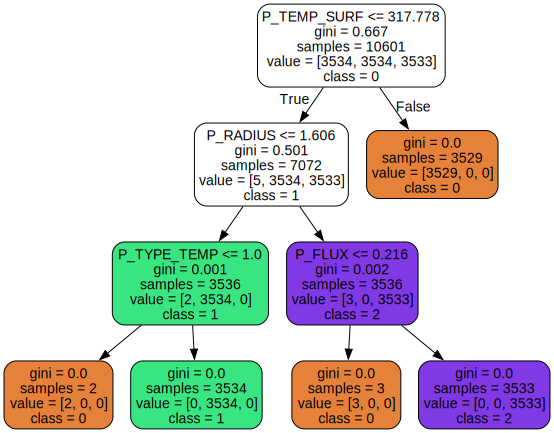

In [ ]:
Source.from_file("/Volumes/Censored/DeepLearning Models/DataSets/Predicting_Exoplanet_Habitability/Exo_planet_habitable.dot")

In [ ]:
accuracy = accuracy_score(y_test_run, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9996226415094339


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_run, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       883
           1       1.00      1.00      1.00       883
           2       1.00      1.00      1.00       884

    accuracy                           1.00      2650
   macro avg       1.00      1.00      1.00      2650
weighted avg       1.00      1.00      1.00      2650



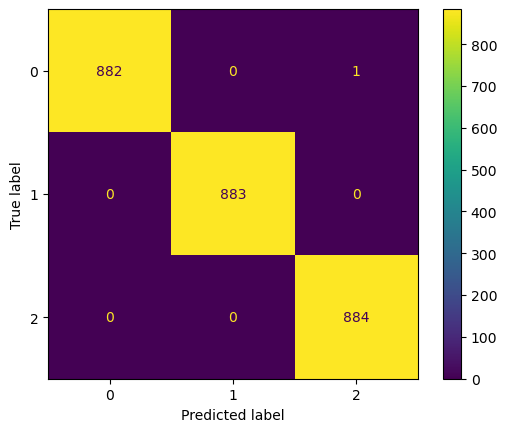

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_run, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
# Train with different random seeds and check consistency
for seed in [42, 100, 200]:
    model = DecisionTreeClassifier(random_state=seed)
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test)
    print(f"Test Accuracy with seed {seed}: {accuracy_score(y_test, y_pred)}")

Test Accuracy with seed 42: 0.9982142857142857
Test Accuracy with seed 100: 0.9991071428571429
Test Accuracy with seed 200: 0.9982142857142857
